In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import json

import cv2

import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.nn as nn
from tqdm import tqdm

# Prepare data

Dataset: [FreiHAND Dataset](https://lmb.informatik.uni-freiburg.de/resources/datasets/FreihandDataset.en.html)

Model's weight: [Weight](https://github.com/OlgaChernytska/2D-Hand-Pose-Estimation-RGB/blob/972c2102d95e14ebb37b1cbd452018ebd6706a44/weights/model_final)

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# В корневую папку Гугл диска необходимо положить архив Hands/FreiHAND.zip
!unzip -o drive/MyDrive/Hands/FreiHAND.zip

# В корневую папку Гугл диска необходимо положить файл Hands/model_final

In [16]:
config = {
    "data_dir": "/content/",
    "model_path": "/content/drive/MyDrive/Hands/model_final",
    "test_batch_size": 4,
    "device": "cpu",
}

#Imported date from open-source project

In [6]:
N_KEYPOINTS = 21
N_IMG_CHANNELS = 3
RAW_IMG_SIZE = 224
MODEL_IMG_SIZE = 128
DATASET_MEANS = [0.3950, 0.4323, 0.2954]
DATASET_STDS = [0.1966, 0.1734, 0.1836]
MODEL_NEURONS = 16


COLORMAP = {
    "thumb": {"ids": [0, 1, 2, 3, 4], "color": "g"},
    "index": {"ids": [0, 5, 6, 7, 8], "color": "c"},
    "middle": {"ids": [0, 9, 10, 11, 12], "color": "b"},
    "ring": {"ids": [0, 13, 14, 15, 16], "color": "m"},
    "little": {"ids": [0, 17, 18, 19, 20], "color": "r"},
}


def projectPoints(xyz, K):
    """
    Projects 3D coordinates into image space.
    Function taken from https://github.com/lmb-freiburg/freihand
    """
    xyz = np.array(xyz)
    K = np.array(K)
    uv = np.matmul(K, xyz.T).T
    return uv[:, :2] / uv[:, -1:]


def get_norm_params(dataloader):
    """
    Calculates image normalization parameters.
    Mean and Std are calculated for each channel separately.
    Borrowed from this StackOverflow discussion:
    https://stackoverflow.com/questions/60101240/finding-mean-and-standard-deviation-across-image-channels-pytorch
    """
    mean = 0.0
    std = 0.0
    nb_samples = 0.0

    for i, sample in tqdm(enumerate(dataloader)):
        data = sample["image_raw"]
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return {"mean": mean, "std": std}


def vector_to_heatmaps(keypoints):
    """
    Creates 2D heatmaps from keypoint locations for a single image
    Input: array of size N_KEYPOINTS x 2
    Output: array of size N_KEYPOINTS x MODEL_IMG_SIZE x MODEL_IMG_SIZE
    """
    heatmaps = np.zeros([N_KEYPOINTS, MODEL_IMG_SIZE, MODEL_IMG_SIZE])
    for k, (x, y) in enumerate(keypoints):
        x, y = int(x * MODEL_IMG_SIZE), int(y * MODEL_IMG_SIZE)
        if (0 <= x < MODEL_IMG_SIZE) and (0 <= y < MODEL_IMG_SIZE):
            heatmaps[k, int(y), int(x)] = 1

    heatmaps = blur_heatmaps(heatmaps)
    return heatmaps


def blur_heatmaps(heatmaps):
    """Blurs heatmaps using GaussinaBlur of defined size"""
    heatmaps_blurred = heatmaps.copy()
    for k in range(len(heatmaps)):
        if heatmaps_blurred[k].max() == 1:
            heatmaps_blurred[k] = cv2.GaussianBlur(heatmaps[k], (51, 51), 3)
            heatmaps_blurred[k] = heatmaps_blurred[k] / heatmaps_blurred[k].max()
    return heatmaps_blurred


class IoULoss(nn.Module):
    """
    Intersection over Union Loss.
    IoU = Area of Overlap / Area of Union
    IoU loss is modified to use for heatmaps.
    """

    def __init__(self):
        super(IoULoss, self).__init__()
        self.EPSILON = 1e-6

    def _op_sum(self, x):
        return x.sum(-1).sum(-1)

    def forward(self, y_pred, y_true):
        inter = self._op_sum(y_true * y_pred)
        union = (
            self._op_sum(y_true ** 2)
            + self._op_sum(y_pred ** 2)
            - self._op_sum(y_true * y_pred)
        )
        iou = (inter + self.EPSILON) / (union + self.EPSILON)
        iou = torch.mean(iou)
        return 1 - iou


def heatmaps_to_coordinates(heatmaps):
    """
    Heatmaps is a numpy array
    Its size - (batch_size, n_keypoints, img_size, img_size)
    """
    batch_size = heatmaps.shape[0]
    sums = heatmaps.sum(axis=-1).sum(axis=-1)
    sums = np.expand_dims(sums, [2, 3])
    normalized = heatmaps / sums
    x_prob = normalized.sum(axis=2)
    y_prob = normalized.sum(axis=3)

    arr = np.tile(np.float32(np.arange(0, 128)), [batch_size, 21, 1])
    x = (arr * x_prob).sum(axis=2)
    y = (arr * y_prob).sum(axis=2)
    keypoints = np.stack([x, y], axis=-1)
    return keypoints / 128


def show_data(dataset, n_samples=12):
    """
    Function to visualize data
    Input: torch.utils.data.Dataset
    """
    n_cols = 4
    n_rows = int(np.ceil(n_samples / n_cols))
    plt.figure(figsize=[15, n_rows * 4])

    ids = np.random.choice(dataset.__len__(), n_samples, replace=False)
    for i, id_ in enumerate(ids, 1):
        sample = dataset.__getitem__(id_)

        image = sample["image_raw"].numpy()
        image = np.moveaxis(image, 0, -1)
        keypoints = sample["keypoints"].numpy()
        keypoints = keypoints * RAW_IMG_SIZE

        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)
        plt.scatter(keypoints[:, 0], keypoints[:, 1], c="k", alpha=0.5)
        for finger, params in COLORMAP.items():
            plt.plot(
                keypoints[params["ids"], 0],
                keypoints[params["ids"], 1],
                params["color"],
            )
    plt.tight_layout()
    plt.show()


def show_batch_predictions(batch_data, model):
    """
    Visualizes image, image with actual keypoints and
    image with predicted keypoints.
    Finger colors are in COLORMAP.
    Inputs:
    - batch data is batch from dataloader
    - model is trained model
    """
    inputs = batch_data["image"]
    true_keypoints = batch_data["keypoints"].numpy()
    batch_size = true_keypoints.shape[0]
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.detach().numpy()
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)
    images = batch_data["image_raw"].numpy()
    images = np.moveaxis(images, 1, -1)

    plt.figure(figsize=[12, 4 * batch_size])
    for i in range(batch_size):
        image = images[i]
        true_keypoints_img = true_keypoints[i] * RAW_IMG_SIZE
        pred_keypoints_img = pred_keypoints[i] * RAW_IMG_SIZE

        plt.subplot(batch_size, 3, i * 3 + 1)
        plt.imshow(image)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(batch_size, 3, i * 3 + 2)
        plt.imshow(image)
        for finger, params in COLORMAP.items():
            plt.plot(
                true_keypoints_img[params["ids"], 0],
                true_keypoints_img[params["ids"], 1],
                params["color"],
            )
        plt.title("True Keypoints")
        plt.axis("off")

        plt.subplot(batch_size, 3, i * 3 + 3)
        plt.imshow(image)
        for finger, params in COLORMAP.items():
            plt.plot(
                pred_keypoints_img[params["ids"], 0],
                pred_keypoints_img[params["ids"], 1],
                params["color"],
            )
        plt.title("Pred Keypoints")
        plt.axis("off")
    plt.tight_layout()

#Dataset

In [7]:
class FreiHAND(Dataset):
    """
    Class to load FreiHAND dataset. Only training part is used here.
    Augmented images are not used, only raw - first 32,560 images
    Link to dataset:
    https://lmb.informatik.uni-freiburg.de/resources/datasets/FreihandDataset.en.html
    """

    def __init__(self, config, set_type="train"):
        self.device = config["device"]
        self.image_dir = os.path.join(config["data_dir"], "training/rgb")
        self.image_names = np.sort(os.listdir(self.image_dir))

        fn_K_matrix = os.path.join(config["data_dir"], "training_K.json")
        with open(fn_K_matrix, "r") as f:
            self.K_matrix = np.array(json.load(f))

        fn_anno = os.path.join(config["data_dir"], "training_xyz.json")
        with open(fn_anno, "r") as f:
            self.anno = np.array(json.load(f))

        if set_type == "train":
            n_start = 0
            n_end = 26000
        elif set_type == "val":
            n_start = 26000
            n_end = 31000
        else:
            n_start = 31000
            n_end = len(self.anno)
            
        #n_start = 0
        #n_end = 4

        self.image_names = self.image_names[n_start:n_end]
        self.K_matrix = self.K_matrix[n_start:n_end]
        self.anno = self.anno[n_start:n_end]

        self.image_raw_transform = transforms.ToTensor()
        self.image_transform = transforms.Compose(
            [
                transforms.Resize(MODEL_IMG_SIZE),
                transforms.ToTensor(),
                transforms.Normalize(mean=DATASET_MEANS, std=DATASET_STDS),
            ]
        )

    def __len__(self):
        return len(self.anno)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_raw = Image.open(os.path.join(self.image_dir, image_name))
        image = self.image_transform(image_raw)
        image_raw = self.image_raw_transform(image_raw)
        
        keypoints = projectPoints(self.anno[idx], self.K_matrix[idx])
        keypoints = keypoints / RAW_IMG_SIZE
        heatmaps = vector_to_heatmaps(keypoints)
        keypoints = torch.from_numpy(keypoints)
        heatmaps = torch.from_numpy(np.float32(heatmaps))

        return {
            "image": image,
            "keypoints": keypoints,
            "heatmaps": heatmaps,
            "image_name": image_name,
            "image_raw": image_raw,
        }

In [17]:
test_dataset = FreiHAND(config=config, set_type="test")
test_dataloader = DataLoader(
    test_dataset,
    config["test_batch_size"],
    shuffle=True,
    drop_last=False,
    num_workers=2,
)

#Model

In [8]:
class ConvBlock(nn.Module):
    def __init__(self, in_depth, out_depth):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.BatchNorm2d(in_depth),
            nn.Conv2d(in_depth, out_depth, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_depth),
            nn.Conv2d(out_depth, out_depth, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class ShallowUNet(nn.Module):
    """
    Implementation of UNet, slightly modified:
    - less downsampling blocks
    - less neurons in the layers
    - Batch Normalization added
    
    Link to paper on original UNet:
    https://arxiv.org/abs/1505.04597
    """
    
    def __init__(self, in_channel, out_channel):
        super().__init__()

        self.conv_down1 = ConvBlock(in_channel, MODEL_NEURONS)
        self.conv_down2 = ConvBlock(MODEL_NEURONS, MODEL_NEURONS * 2)
        self.conv_down3 = ConvBlock(MODEL_NEURONS * 2, MODEL_NEURONS * 4)
        self.conv_bottleneck = ConvBlock(MODEL_NEURONS * 4, MODEL_NEURONS * 8)

        self.maxpool = nn.MaxPool2d(2)
        self.upsamle = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)

        self.conv_up1 = ConvBlock(
            MODEL_NEURONS * 8 + MODEL_NEURONS * 4, MODEL_NEURONS * 4
        )
        self.conv_up2 = ConvBlock(
            MODEL_NEURONS * 4 + MODEL_NEURONS * 2, MODEL_NEURONS * 2
        )
        self.conv_up3 = ConvBlock(MODEL_NEURONS * 2 + MODEL_NEURONS, MODEL_NEURONS)

        self.conv_out = nn.Sequential(
            nn.Conv2d(MODEL_NEURONS, out_channel, kernel_size=3, padding=1, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        conv_d1 = self.conv_down1(x)
        conv_d2 = self.conv_down2(self.maxpool(conv_d1))
        conv_d3 = self.conv_down3(self.maxpool(conv_d2))
        conv_b = self.conv_bottleneck(self.maxpool(conv_d3))

        conv_u1 = self.conv_up1(torch.cat([self.upsamle(conv_b), conv_d3], dim=1))
        conv_u2 = self.conv_up2(torch.cat([self.upsamle(conv_u1), conv_d2], dim=1))
        conv_u3 = self.conv_up3(torch.cat([self.upsamle(conv_u2), conv_d1], dim=1))

        out = self.conv_out(conv_u3)
        return out

In [11]:
model = ShallowUNet(3, 21)
model.load_state_dict(
    torch.load(config["model_path"], map_location=torch.device(config["device"]))
)
model.eval()
print("Model loaded")

Model loaded


# Metrics

## Object Keypoint Similarity

In [12]:
def oks(y_true, y_pred, visibility):
    # You might want to set these global constant
    # outside the function scope
    KAPPA = np.array([1] * len(y_true))
    # The object scale
    # You might need a dynamic value for the object scale
    SCALE = 1.0

    # Compute the L2/Euclidean Distance
    distances = np.linalg.norm(y_pred - y_true, axis=-1)
    # Compute the exponential part of the equation
    exp_vector = np.exp(-(distances**2) / (2 * (SCALE**2) * (KAPPA**2)))
    # The numerator expression
    numerator = np.dot(exp_vector, visibility.astype(bool).astype(int))
    # The denominator expression
    denominator = np.sum(visibility.astype(bool).astype(int))
    return numerator / denominator

In [19]:
predictions = []
targets = []

for data in tqdm(test_dataloader):
    inputs = data["image"]
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.detach().numpy()
    true_keypoints = data["keypoints"].numpy()
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)

    pred_keypoints = pred_keypoints.reshape(-1, 3)
    predictions.extend(pred_keypoints)
    true_keypoints = true_keypoints.reshape(-1, 3)
    targets.extend(true_keypoints)

targets = np.array(targets)
predictions = np.array(predictions)

print('Test OKS:', oks(targets[:, :2], predictions[:, :2], targets[:, 2]))

100%|██████████| 390/390 [01:59<00:00,  3.25it/s]

Test OKS: 0.9983032275185367


In [20]:
print('Test OKS:', oks(targets[:, :2], predictions[:, :2], targets[:, 2]))

Test OKS: 0.9983032275185367


#Inference

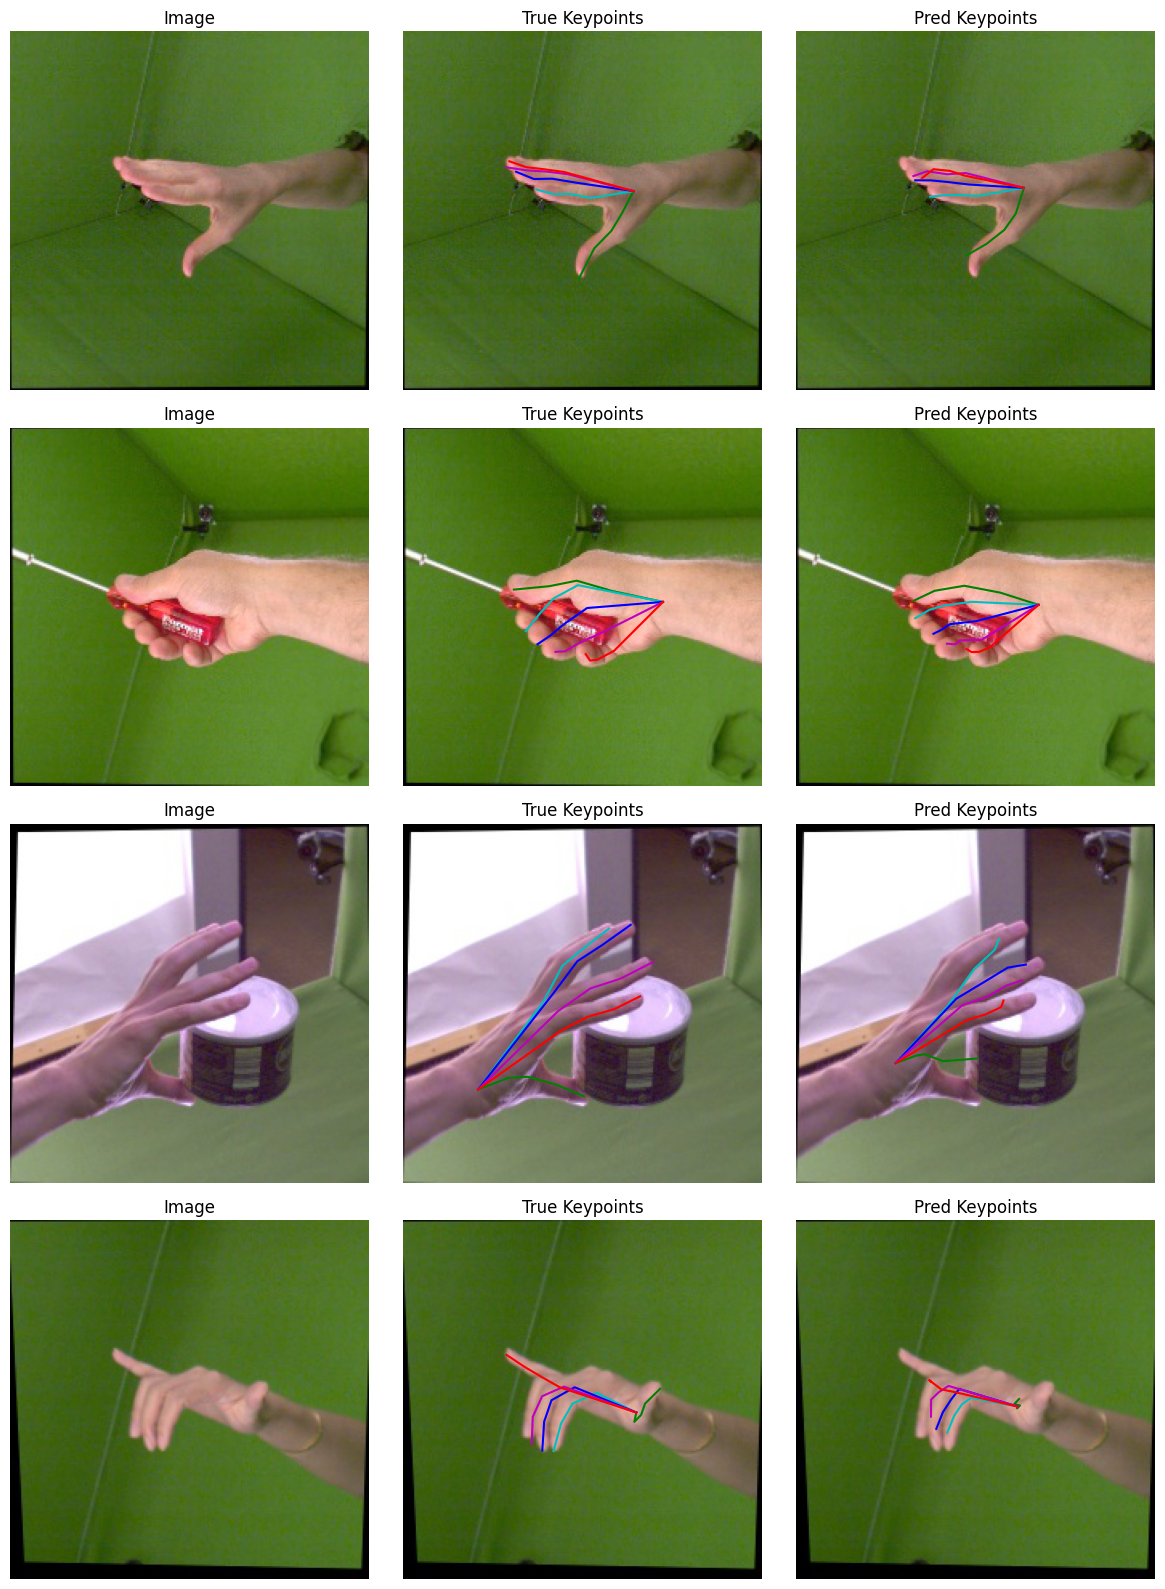

In [21]:
for data in test_dataloader:
    show_batch_predictions(data, model)
    break